# Running the pgmpy example.
Sampling from 2D gaussian with fixed mean and covariance using Hamiltonian Monte Carlo.  
Basically we found out that pgmpy is very unstable on large scale models, so I decided to switch to Edward.

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pystan

In [34]:
from pgmpy.sampling import HamiltonianMC as HMC, LeapFrog, GradLogPDFGaussian
from pgmpy.factors.distributions import GaussianDistribution as JGD
from pgmpy.factors.distributions import BaseDistribution as BD
import numpy as np

In [35]:
mean = np.array([-3, 4])
covariance = np.array([[3, 0.7], [0.7, 5]])
model = JGD(['x', 'y'], mean, covariance)
sampler = HMC(model=model, grad_log_pdf=GradLogPDFGaussian, simulate_dynamics=LeapFrog)
samples = sampler.sample(initial_pos=np.array([1, 1]), num_samples = 10000, trajectory_length=2, stepsize=0.4)

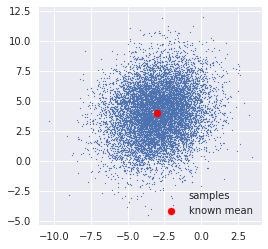

In [36]:
plt.figure(figsize=(4,4))
plt.scatter(samples['x'].as_matrix(),samples['y'].as_matrix(), label="samples", s=1)
plt.scatter([-3],[4], color="red", label="known mean")
plt.legend()
plt.show()

# Using simple linear regression model with wine data.

We use the wine quality data from UCI ML repository. We will formulate this into a linear regression problem where target is the wine quality values and predictors (11 features) are wine properties.

Loading data...

In [37]:
# loading
wine = [[float(j) for j in i.rstrip().split(";")] for i in open("wine_data/winequality-white.csv").readlines()[1:]]
wine = np.array(wine)
X = wine[:,:-1]
d = X.shape[1]
n = X.shape[0]
Y = wine[:,-1].reshape((n,1))

# normalizing 
X = X-np.min(X, axis=0)
X = np.divide(X, np.max(X, axis=0)*1.0)

Calcuating the closed form solution for ridge regression...

In [38]:
XtX = np.linalg.inv(np.dot(np.transpose(X), X)+np.eye(d))
XtY = np.dot(np.transpose(X), Y)
W = np.dot(XtX, XtY)

In [39]:
results = {}

# Sampling with Random Walk Metropolis Hastings


We use self implemented random walk metrolpolis hastings approach to sample from the posterior distribution of weights.  
Here is the likelihood function we use.  
$ln(P(w|y,x))\propto ln(p(y|w,x))+ln(p(w)) \propto -\frac{(y-w\cdot x)^2}{2} - \frac{(w)^2}{2} $

In [8]:
def logL(W):
    return -1*np.sum(np.square((Y-np.dot(X,W))))/2.0-np.sum(np.square(W))/2.0

In [9]:
epsilon = 0.05 # scaling of gaussian noise added to find the next set of weights
sample = 100000 # num samples

In [10]:
#Parameter initialization
curW = W[:]
PosteriorW = []
count = 0
accept = 0
while (count<sample):
    # Adding gaussian distributed noise
    noise = epsilon*(np.random.normal(size=d).reshape(d,1))
    nextW = curW+noise

    # Draw from log uniform [0,1]. Compare in log space
    loga = np.log(np.random.rand())
    
    # Evaulate transition
    if loga < logL(nextW)-logL(curW): #accept
        PosteriorW.append(nextW)
        curW = nextW
        accept += 1
    else: #reject
        PosteriorW.append(curW)
        curW = curW
    count += 1

PosteriorW = np.array(PosteriorW)[:,:,0]
results["RWMH"] = PosteriorW

print "Sampled", sample, "examples"
print "Acceptance rate", accept*1.0/count

Sampled 100000 examples
Acceptance rate 0.2644


Here is the posterior distribution of 11 weights estimated by random walk metropolis hastings. 

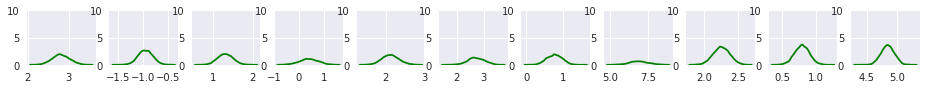

In [11]:
plt.figure(figsize=(16,1))
for i in range(d):
    plt.subplot(1,11,i+1)
    sns.distplot(results["RWMH"][:,i], hist=False, color="green")
    plt.ylim(0,10)
plt.savefig("scalerLR.png")
plt.show()

# Using Edward to do sgHMC sampling.

We use Edward, a posterior sampling tool built on tensorflow, to estiamte the same posterior distributiosn as above.

In [40]:
from __future__ import absolute_import
from __future__ import division

import edward as ed
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

from edward.models import Normal, Empirical

In [41]:
# MODEL
X_holder = tf.placeholder(tf.float32, [n, d])
w = Normal(loc=tf.zeros(d), scale=tf.ones(d))
Y_holder = Normal(loc=ed.dot(X_holder, w), scale=tf.ones(n))

In [42]:
# INFERENCE
T = 10000                        # Number of samples.
nburn = 100                     # Number of burn-in samples.
stride = 10                    # Frequency with which to plot samples.
qw = Empirical(params=tf.Variable(tf.random_normal([T, d])))

inference = ed.SGHMC({w: qw}, data={X_holder: X, Y_holder: Y[:, 0]})
inference.run(step_size=1e-3)

10000/10000 [100%] ██████████████████████████████ Elapsed: 24s | Acceptance Rate: 1.000


In [23]:
results["Edward"] = qw.params.eval()[nburn:T]

Here is the plot. The green lines are the estimated posterior distributions with Edward using sgHMC. The blue lines is the posterior distirbution estimated by random walk metropolis hastings. You can see that Edward's estimation is bit noisy but mostly correct.

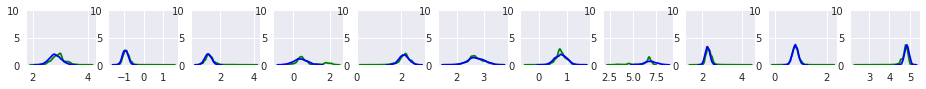

In [25]:
plt.figure(figsize=(16,1))
for i in range(d):
    plt.subplot(1,11,i+1)
    sns.distplot(results["Edward"][:,i], hist=False, color="green")
    sns.distplot(results["RWMH"][:,i], hist=False, color="blue")
    plt.ylim(0,10)
plt.show()